# Розв'язання прямої та оберненої задач дифузії з використанням Python 3.7 та Jupyter Notebook
Залежність коефіцієнта дифузії для даної задачі наступна:
$$D(c) = 1\cdot 10^{-15} + 6 \cdot 10^{-15} c  -4 \cdot 10^{-15} c^{2}  $$

Будемо розв'язувати рівняння дифузії речовини згідно другого закону Фіка (одновимірний випадок): 

$$\frac{\partial c}{\partial t} = \frac{\partial}{\partial x}\bigg(D(c)\cdot\frac{\partial c}{\partial x}\bigg)$$

<IPython.core.display.Javascript object>


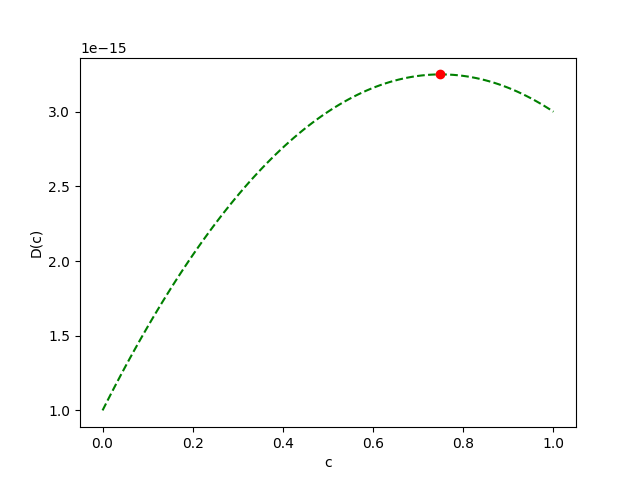

In [1]:
%matplotlib notebook
import numpy as np 
import matplotlib.pyplot as plt


# constants
NPOINTS = 100


###########################

def vectorize(func):
    """
    Vectorize decorator for python functions
    """
    def wrapper(vector):
        fn = np.vectorize(func)
        return fn(vector)
    return wrapper

@vectorize
def Dc(c: float)->float:
    return 1e-15  + 6e-15*c-4e-15*c**2


def plot_dc():
    c = np.linspace(0,1, NPOINTS)
    D = Dc(c)
    max_D_index = np.argmax(D) # Find the diffusion coefficient maxima index
    fig = plt.figure('Залежність коефіцієнта дифузії від концентрації')
    ax = fig.add_subplot(111)
    plt.ion()
    fig.show()
    ax.clear()
    ax.set_ylabel('D(c)')
    ax.set_xlabel('c')
    ax.plot(c,D,'g--', c[max_D_index], D[max_D_index], 'ro') # show on plot D(c) and maxima of D(c)
    fig.canvas.draw()
plot_dc()


    Diffusion area distance: 2e-06 m 

    delta x: 2.000000000000002e-08 

    delta t: 0.012307788905283674 

    time: 2 s 

    
Solution completed


<IPython.core.display.Javascript object>


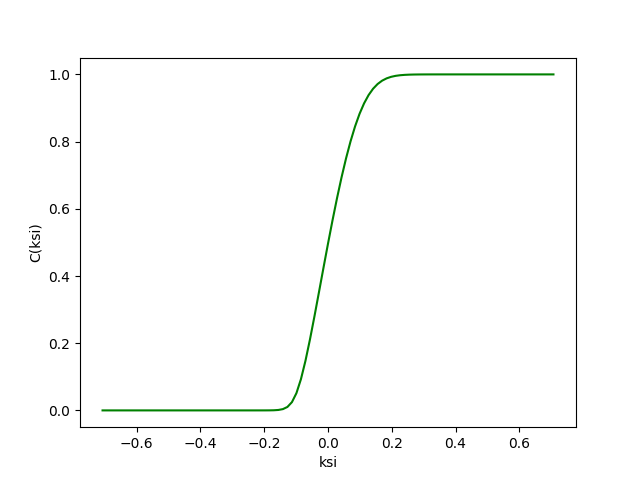

In [2]:
# constants for Diffusion PDE
LEFT_BOUND = -1e-6
RIGHT_BOUND = 1e-6
MAX_TIME = 2
NOISE_AMPLITUDE = 4 # in percent

@vectorize
def initial_c(x):
    if x>0:
        return 1
    else:
        return 0
    
def get_max_D():
    c = np.linspace(0,1, NPOINTS)
    D = Dc(c)
    return np.max(D)

def solve_direct(TMAX: float):
    
    x = np.linspace(LEFT_BOUND,RIGHT_BOUND, NPOINTS+1) # set x vector

    DX2 = (x[1]-x[0])**2 # set dx2
    DX = x[1]-x[0]
    # calculate dt
    DT = (0.1*(DX**2))/get_max_D()
  
    
    koef = DT/DX2
    t = 0

    # initial condition
    c = np.array(initial_c(x), dtype=np.float64) 
  
    c_new = c.copy()
    
    
    # solution  of equation
    while t < TMAX:
        
        D = Dc(c)    
        c_new[1:-1] = c[1:-1] + 0.5*koef*((D[2:]+D[1:-1])*(c[2:]-c[1:-1]) - (D[0:-2]+D[1:-1])*(c[1:-1]-c[0:-2]))
        
        c_new[0] = 0
        c_new[NPOINTS] = 1
        curr_c = c.copy()
        next_c = c_new.copy()
        
        c = c_new.copy()
        
        t+=DT
    print(f"""
    Diffusion area distance: {RIGHT_BOUND-LEFT_BOUND} m \n
    delta x: {DX} \n
    delta t: {DT} \n
    time: {TMAX} s \n
    """)
    
    return x, c

x, c = solve_direct(MAX_TIME) # 5 seconds
print('Solution completed')
ksi = x/np.sqrt(MAX_TIME) # set ksi for Boltzmann substitution

%matplotlib notebook
fig = plt.figure('Профіль концентрації')
ax = fig.add_subplot(111)
fig.show()   
ax.clear()
ax.set_ylabel('С(ksi)')
ax.set_xlabel('ksi')
ax.plot(ksi/1e-6,c,'g-') 
fig.canvas.draw()
        

## Спотворення розв'язку прямої задачі дифузії для моделювання отримання експериметального профілю

<IPython.core.display.Javascript object>


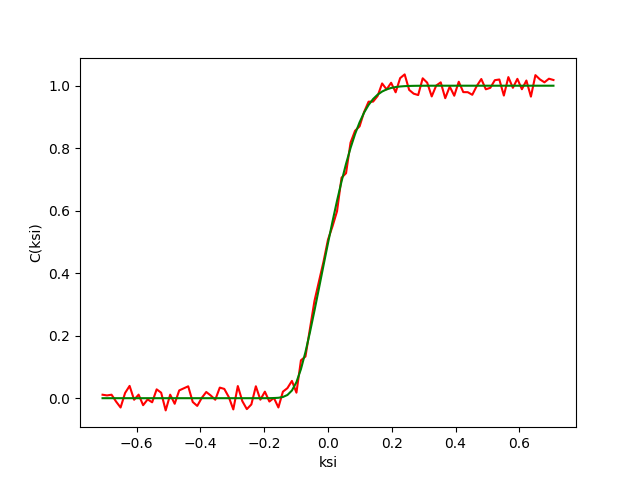

In [3]:
%matplotlib notebook
from numpy import random as rnd
def avg_smoothing(x, n):
    xn = x.copy()
    for i in range(x.shape[0]-n):
        avg = np.sum(x[i:i+n])/n
        xn[i] = avg
    for i in range(x.shape[0]-1, x.shape[0]+1-n, -1):
        avg = np.sum(x[i-n:i])/n
        xn[i] = avg
    return xn

An = NOISE_AMPLITUDE # 0.0001 percent noise

def noise_concentration_profiles(c, An):
    rnd.seed()
    noise = An*(2*np.random.uniform(size=NPOINTS+1)-1) # (1 + An * (2*rnd.random(NPOINTS+1) - 1))
    return c + noise

cn = noise_concentration_profiles(c, An*0.01)
# cn[cn < 0] = 0
# cn [cn > 1] = 1
fig = plt.figure('Cпотворений профіль концентрації ')
ax = fig.add_subplot(111)
fig.show()
ax.clear()
ax.set_ylabel('С(ksi)')
ax.set_xlabel('ksi')
ax.plot(ksi/1e-6,cn,'r-',ksi/1e-6, c, 'g-') 
fig.canvas.draw()


<IPython.core.display.Javascript object>


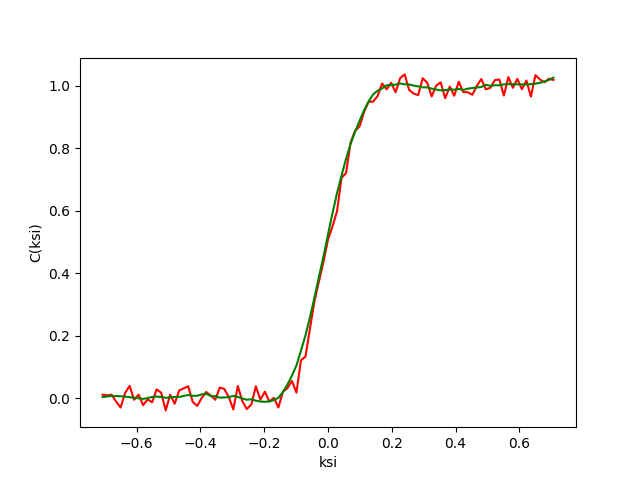

In [4]:
%matplotlib notebook
from scipy.signal import savgol_filter

c_filtered = savgol_filter(cn, 20, polyorder=3)
fig = plt.figure('Відфільтрований профіль концентрації ')
ax = fig.add_subplot(111)
fig.show()
ax.clear()
ax.set_ylabel('С(ksi)')
ax.set_xlabel('ksi')
ax.plot(ksi/1e-6,cn,'r-',ksi/1e-6, c_filtered, 'g-') 
fig.canvas.draw()
cn = c_filtered.copy()

**Розрахуємо похідні спотвореного розв'язку прямої задачі дифузії.**

<IPython.core.display.Javascript object>


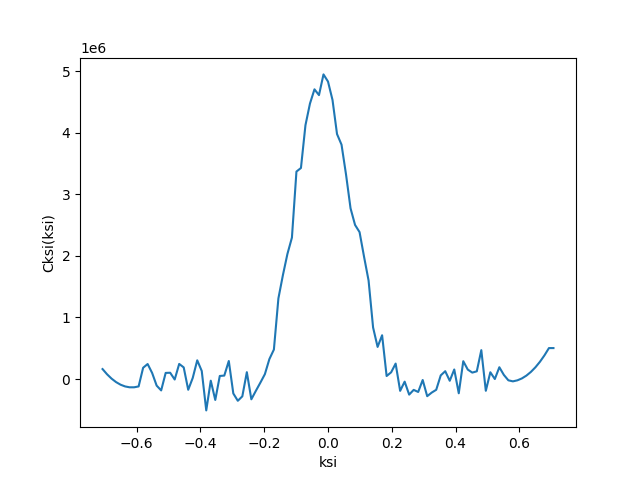

In [5]:
cksi = np.zeros(NPOINTS+1, dtype=np.float64)
cksi[0:-1] = (cn[1:] - cn[0:-1])/(ksi[1] - ksi[0])
cksi[NPOINTS] = cksi[NPOINTS-1]
#cksi = avg_smoothing(cksi.copy(), 3)

# plot derivative Cx
%matplotlib notebook
fig = plt.figure('Профіль першої похідної від концентрації по координаті ')
ax = fig.add_subplot(111)
fig.show()
ax.clear()
ax.set_ylabel('Сksi(ksi)')
ax.set_xlabel('ksi')
ax.plot(ksi / 1e-6,cksi) 
fig.canvas.draw()


<IPython.core.display.Javascript object>


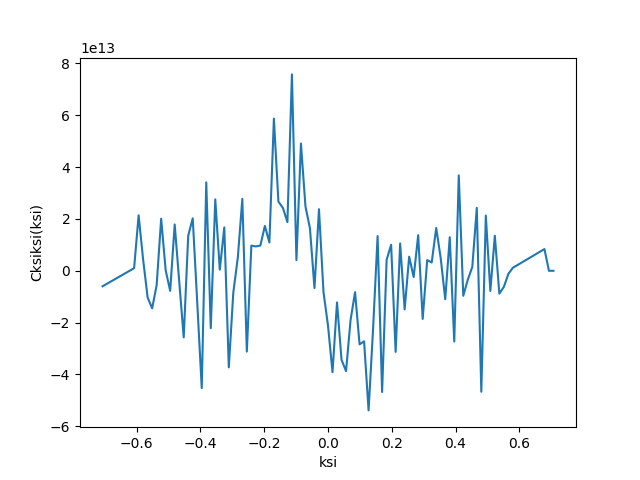

In [6]:
cksiksi = np.zeros(NPOINTS+1,dtype=np.float64)
cksiksi[0:-1] = (cksi[1:] - cksi[0:-1])/(ksi[1] - ksi[0])
cksiksi[NPOINTS] = cksiksi[NPOINTS-1]

# plot derivative Cxx
%matplotlib notebook
fig = plt.figure('Профіль другої похідної від концентрації по координаті ')
ax = fig.add_subplot(111)
fig.show()
ax.clear()
ax.set_ylabel('Cksiksi(ksi)')
ax.set_xlabel('ksi')
ax.plot(ksi / 1e-6,cksiksi) 
fig.canvas.draw()

 final_simplex: (array([[2.77318115],
       [2.77317505]]), array([0.00168223, 0.00168223]))
           fun: 0.0016822256995689378
       message: 'Optimization terminated successfully.'
          nfev: 58
           nit: 29
        status: 0
       success: True
             x: array([2.77318115])


<IPython.core.display.Javascript object>


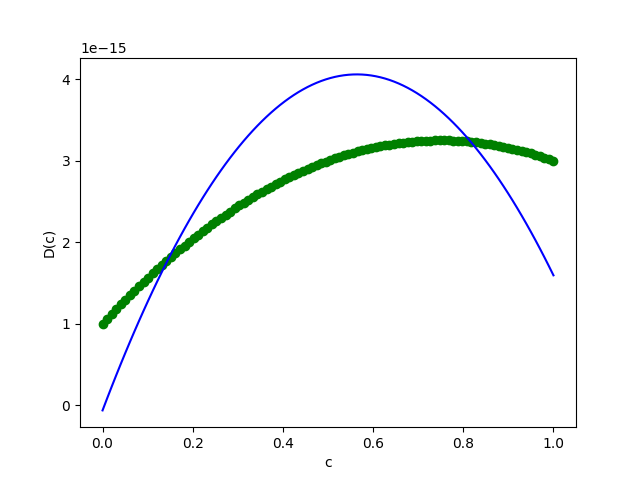

a=[-1.29686362e-14  1.46267055e-14 -6.41561176e-17]


In [7]:
from scipy import linalg
import scipy.optimize as optimize

def d_aproxim(c,a1,a2,a3):
    return a1*c**2 + a2*c + a3

def getMaxAproximD(a1,a2,a3):
    c = np.linspace(0,1,NPOINTS)
    D = d_aproxim(c, a1,a2,a3)
    return np.max(D)
def getMinAproximD(a1,a2,a3):
    c = np.linspace(0,1,NPOINTS)
    D = d_aproxim(c, a1,a2,a3)
    return np.min(D)
def solve_direct_with_approxim(TMAX: float, a1:float,a2:float, a3: float)->tuple:
    
    x = np.linspace(LEFT_BOUND,RIGHT_BOUND, NPOINTS+1) # set x vector

    DX2 = (x[1]-x[0])**2 # set dx2
    DX = x[1]-x[0]
    # calculate dt
    DT = (0.1*(DX**2))/getMaxAproximD(a1,a2,a3)
  
    
    koef = DT/DX2
    t = 0

    # initial condition
    c = np.array(initial_c(x), dtype=np.float64) 
  
    c_new = c.copy()
    #if getMinAproximD(a1,a2,a3) < 0:
        #return x,c 
    #solution  of equation
    while t < TMAX:
        
        D = d_aproxim(c,a1,a2,a3)    
        D[D < 0] = 0
        c_new[1:-1] = c[1:-1] + 0.5*koef*((D[2:]+D[1:-1])*(c[2:]-c[1:-1]) - (D[0:-2]+D[1:-1])*(c[1:-1]-c[0:-2]))
        
        c_new[0] = 0
        c_new[NPOINTS] = 1
        c = c_new.copy()
        
        t+=DT
    return x, c

def mnfunc(params):
    alpha = params
    m1 = -0.5*np.sum(ksi*cksi*(2*cn*cksi**2 + cn**2*cksiksi))
    k11 = 2*np.sum( cn * cksi**2 * (2*cn*cksi**2 + cn**2*cksiksi)) + \
    np.sum(cn**2*cksiksi*(2*cn*cksi**2 + cn**2*cksiksi)) - alpha*np.sum(cn**4*cksi**4)
    
    k12 = np.sum(cksi**2*(2*cn*cksi**2 + cn**2*cksiksi)) + \
    np.sum(cn*cksiksi*(2*cn*cksi**2 + cn**2*cksiksi)) - alpha*np.sum(cn**3*cksi**4)
    k13 = np.sum(cksiksi*(2*cn*cksi**2 + cn**2*cksiksi)) - alpha*np.sum(cn**2*cksi**4)

    m2 = -0.5*np.sum(ksi*cksi*(cksi**2 + cn*cksiksi))
    k21 = 2*np.sum(cn*cksi**2*(cksi**2 + cn*cksiksi)) + \
    np.sum(cn**2*cksiksi*(cksi**2 + cn*cksiksi)) - alpha*np.sum(cn**3*cksi**4)
    
    k22 = np.sum(cksi**2*(cksi**2 + cn*cksiksi)) + \
    np.sum(cn*cksiksi*(cksi**2 + cn*cksiksi)) - alpha*np.sum(cn**2*cksi**4)
    k23 = np.sum(cksiksi*(cksi**2 + cn*cksiksi)) - alpha*np.sum(cn*cksi**4)

    m3 = -0.5*np.sum(ksi*cksi*cksiksi)
    k31 = 2*np.sum(cn*cksi**2*cksiksi) + np.sum(cn**2*cksiksi**2) - alpha*np.sum(cn**2*cksi**4)
    k32 = np.sum(cksi**2*cksiksi) + np.sum(cn*cksiksi**2) - alpha*np.sum(cn*cksi**4)
    k33 = np.sum(cksiksi**2) - alpha*np.sum(cksi**4)


    A = np.array([[k11,k12,k13], [k21,k22,k23], [k31,k32,k33]])
    B = np.array([m1,m2,m3])
    a = linalg.solve(A, B)
    x, c_approxim = solve_direct_with_approxim(MAX_TIME,a[0],a[1],a[2])
    return (1.0/c.shape[0])*np.sqrt(np.sum((cn - c_approxim)**2))
    
result = optimize.minimize(mnfunc, 1, method='Nelder-Mead', tol=1e-5)

print(result)
# calculate sums
alpha = result.x
m1 = -0.5*np.sum(ksi*cksi*(2*cn*cksi**2 + cn**2*cksiksi))
k11 = 2*np.sum( cn * cksi**2 * (2*cn*cksi**2 + cn**2*cksiksi)) + \
np.sum(cn**2*cksiksi*(2*cn*cksi**2 + cn**2*cksiksi)) - alpha*np.sum(cn**4*cksi**4)
    
k12 = np.sum(cksi**2*(2*cn*cksi**2 + cn**2*cksiksi)) + \
np.sum(cn*cksiksi*(2*cn*cksi**2 + cn**2*cksiksi)) - alpha*np.sum(cn**3*cksi**4)
k13 = np.sum(cksiksi*(2*cn*cksi**2 + cn**2*cksiksi)) - alpha*np.sum(cn**2*cksi**4)

m2 = -0.5*np.sum(ksi*cksi*(cksi**2 + cn*cksiksi))
k21 = 2*np.sum(cn*cksi**2*(cksi**2 + cn*cksiksi)) + \
np.sum(cn**2*cksiksi*(cksi**2 + cn*cksiksi)) - alpha*np.sum(cn**3*cksi**4)
    
k22 = np.sum(cksi**2*(cksi**2 + cn*cksiksi)) + \
np.sum(cn*cksiksi*(cksi**2 + cn*cksiksi)) - alpha*np.sum(cn**2*cksi**4)
k23 = np.sum(cksiksi*(cksi**2 + cn*cksiksi)) - alpha*np.sum(cn*cksi**4)

m3 = -0.5*np.sum(ksi*cksi*cksiksi)
k31 = 2*np.sum(cn*cksi**2*cksiksi) + np.sum(cn**2*cksiksi**2) - alpha*np.sum(cn**2*cksi**4)
k32 = np.sum(cksi**2*cksiksi) + np.sum(cn*cksiksi**2) - alpha*np.sum(cn*cksi**4)
k33 = np.sum(cksiksi**2) - alpha*np.sum(cksi**4)


A = np.array([[k11,k12,k13], [k21,k22,k23], [k31,k32,k33]])
B = np.array([m1,m2,m3])
a = linalg.solve(A, B)
# calculate coefficient a and b for D(c) = ac+b
c_ax = np.linspace(0,1, 100)
D_aproxim = d_aproxim(c_ax,a[0],a[1],a[2])
D_real = Dc(c_ax)

# plot aproxim
%matplotlib notebook
fig = plt.figure('Теоретична та відновлена з оберненої задачі залежність коефіцієнта дифузії ')
ax = fig.add_subplot(111)
fig.show()
ax.clear()
ax.set_ylabel('D(c)')
ax.set_xlabel('c')
ax.plot(c_ax,np.round(D_real,20), 'go-', c_ax, np.round(D_aproxim,20), 'b-') 

#ax.plot( c_ax, np.round(D_aproxim, 17), 'b-') 
fig.canvas.draw()
print(f"a={a}")

Синім позначено залежність коефіцієнта дифузії отриманого з оберненої задачі,  зеленим - теоретично заданий коефіцієнт дифузії.

In [8]:
x, c_approxim = solve_direct_with_approxim(MAX_TIME,a[0],a[1],a[2]) # 5 seconds
print('Solution completed')

Solution completed


Розрахуємо нев'язку розв'язку прямої задачі дифузії з використанням наближення коефіцієнта дифузії.


In [9]:
eta = (1.0/c.shape[0])*np.sqrt(np.sum((cn-c_approxim)**2))
eta

0.0016822256995689378

<IPython.core.display.Javascript object>


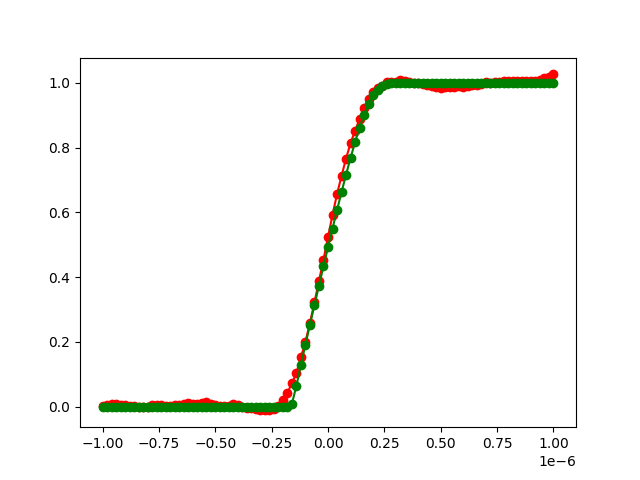

In [10]:
%matplotlib notebook
fig = plt.figure('Профіль  концентрації (наближений)')
ax = fig.add_subplot(111)
fig.show()
ax.plot(x, cn, 'ro-', x, c_approxim, 'go-')
fig.canvas.draw()